# Fuel Performance

**Inputs**

- `fuel_dens`: Fuel density ($\frac{kg}{m^3}$)
- `porosity`: Porosity 
- `clad_thick`: Cladding thickness ($m$)
- `pellet_OD`: Pellet outer diameter ($m$)
- `pellet_h`: Pellet height ($m$)
- `gap_thick`: Gap thickness ($m$)
- `inlet_T`: Inlet temperature ($K$)
- `enrich`: U-235 enrichment
- `rough_fuel`: Fuel roughness ($m$)
- `rough_clad`: Clad rouchness ($m$)
- `ax_pow`: Axial power
- `clad_T`: Cladding surface temperature ($K$)
- `pressure`: Pressure ($Pa$)

**Outputs**

- `fis_gas_produced`: Fission gas production ($mol$)
- `max_fuel_centerline_temp`: Max fuel centerline temperature ($K$)
- `max_fuel_surface_temp`: Max fuel surface temperature ($K$)
- `radial_clad_dia`: Radial cladding diameter displacement after irradiation ($m$)

This data set consists of 13 inputs and 4 outputs with 400 data points. This data originates from [1], and a graphical representation is provided in the figure below. Case 1 from the pellet-cladding mechanical interaction (PCMI) benchmark [2] was selected for the data set. This benchmark simulates a beginning of life (BOL) ramp of a 10-pellet pressurized water reactor (PWR) fuel rod to an average linear heat rate of $40~kW/m$. The inner and outer cladding diameters are reduced, so the fuel-clad interaction occurs during the ramp time. Axial power and rod surface temperature profiles were assumed to be uniform at $330^\circ C$. The 13 input parameters were uniformly randomly sampled independently within their uncertainty bounds and simulated in BISON. The rod response was recorded in 4 outputs.

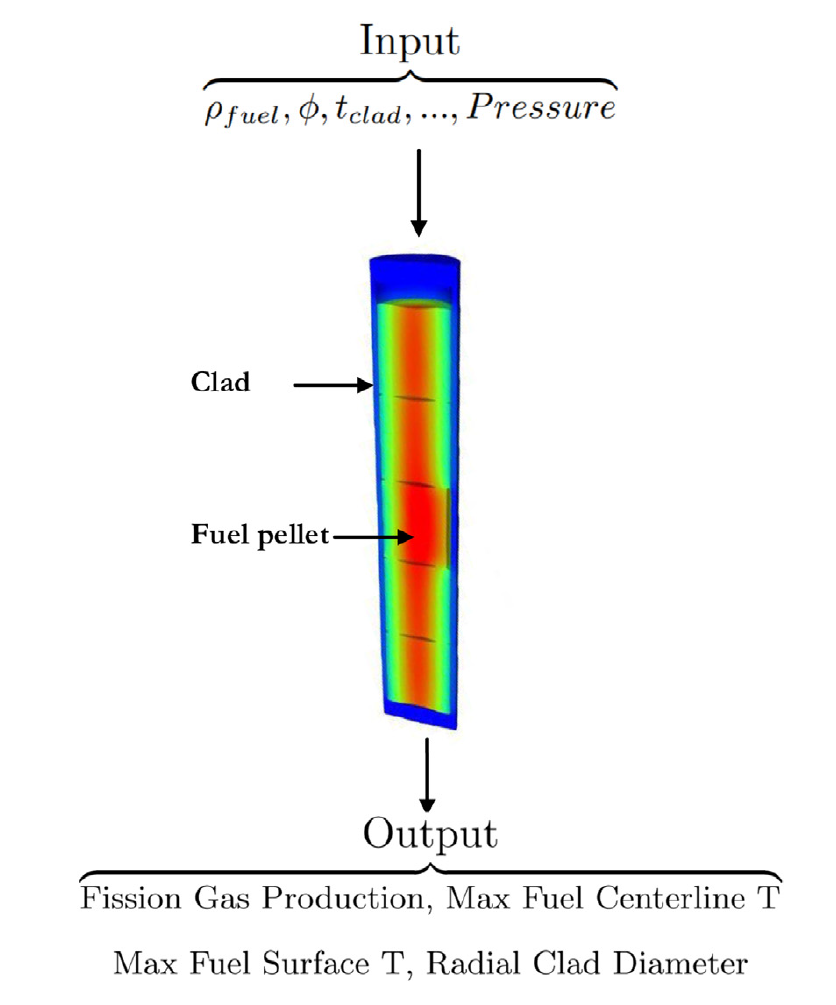


The following are a few common packages and functions that will prove useful while using pyMAISE along with pyMAISE specific functionality. 

In [30]:
# Importing Packages
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# pyMAISE specific imports
import pyMAISE as mai
from pyMAISE.datasets import load_fp
from pyMAISE.preprocessing import scale_data, train_test_split, correlation_matrix

## pyMAISE Initialization

We first start by initializing pyMAISE settings and then import the data set using `load_fp()` from the pyMAISE dataset library.

In [31]:
# Settings 
settings = {
    "verbosity": 0,
    "random_state": 42,
    "test_size": 0.3,
    "num_configs_saved": 5,
    "cuda_visible_devices": "-1", # Use CPUs only
}

# Problem type for a regression, problem = 0
problem_type = mai.ProblemType(0)

# Initializing pyMaise settings
global_settings = mai.settings.init(problem_type=mai.ProblemType.REGRESSION, settings_changes=settings)

# Get data from repoisitory
data, inputs, outputs = load_HTGR()

As stated the data set consists of 13 inputs:

In [32]:
inputs

<xarray.DataArray (index: 400, variable: 13)>
array([[1.0466e+04, 4.0527e-02, 5.7110e-04, ..., 9.9967e-01, 6.0272e+02,
        1.5504e+07],
       [1.0488e+04, 4.1780e-02, 5.6984e-04, ..., 9.8741e-01, 6.0281e+02,
        1.5591e+07],
       [1.0434e+04, 5.8323e-02, 5.6760e-04, ..., 9.9225e-01, 6.2033e+02,
        1.5510e+07],
       ...,
       [1.0474e+04, 4.9933e-02, 5.6787e-04, ..., 9.7834e-01, 5.9643e+02,
        1.5645e+07],
       [1.0456e+04, 4.4766e-02, 5.7574e-04, ..., 9.5912e-01, 5.9159e+02,
        1.5441e+07],
       [1.0438e+04, 5.5806e-02, 5.7198e-04, ..., 9.9917e-01, 6.0763e+02,
        1.5379e+07]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * variable  (variable) object 'fuel_dens' 'porosity' ... 'clad_T' 'pressure'

and 4 outputs with 400 total data points:

In [33]:
outputs

<xarray.DataArray (index: 400, variable: 4)>
array([[2.95000000e-05, 1.56969931e+03, 6.99613033e+02, 1.88000000e-05],
       [3.17000000e-05, 1.55946516e+03, 6.99976191e+02, 1.87000000e-05],
       [3.11000000e-05, 1.63239410e+03, 7.12771506e+02, 2.02000000e-05],
       ...,
       [3.04000000e-05, 1.55122859e+03, 6.92270857e+02, 1.81000000e-05],
       [3.09000000e-05, 1.50301759e+03, 6.83481715e+02, 1.72000000e-05],
       [3.17000000e-05, 1.62006353e+03, 7.04130846e+02, 1.98000000e-05]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * variable  (variable) object 'fis_gas_produced' ... 'radial_clad_dia'

Prior to constructing any models we can get a surface understanding of the data set with a correlation matrix.

(<Figure size 640x480 with 2 Axes>, <AxesSubplot:>)

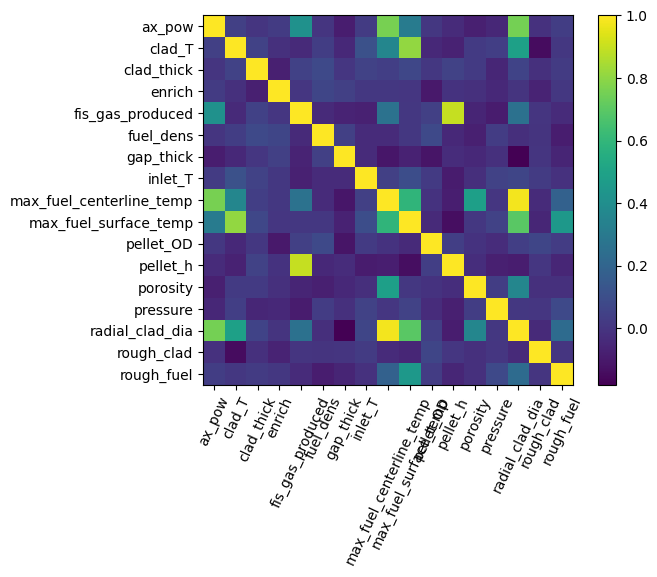

In [34]:
correlation_matrix(data)

There is a positive correlation between axial power and cladding temperature with max fuel centerline temperature, max fuel surface temperature, and radial cladding diameter. Additionally, the fission gas production correlates with pellet height.

The final step of the pyMAISE processing is splitting and data scaling. For this data set we will use min-max scaling.

In [35]:
# Train test split data
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.30)

# Min-Max scaling data 
xtrain, xtest, _ = scale_data(xtrain, xtest, MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, MinMaxScaler())
data = (xtrain, xtest, ytrain, ytest)

## Model Initialization

We will examine the performance of 6 models in this data set:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential dense neural networks: `FNN`.

For hyper-parameter tuning each model we must be initialized the archetecture and optimization search spaces.

In [36]:
# Initializing all the models wanted along with neurel network archetecture/optimization hps
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=2),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
# Constructing Tuner object for the search space above
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyper-parameter Tuning

We will use random search for the hyper-parameter tuning of the classical models (`Lasso`, `DT`, `RF`, and `KN`) through the `random_search` function. `Linear` will be manually fit with the Scikit-learn defaults. For each classical model 300 models will be produced with randomly sampled parameter configurations. For `nn`, bayesian search is used to optimize the hyper-parameters in 50 iterations through the `bayesian_search` function. Bayesian search is appealing for `nn` as their training can be computationally expensive. To further reduce the computational cost of `nn` we specify only 10 epochs which will produce less than performant models but show the optimal parameters. For both search methods we use cross-validation to reduce bias in the models from the data set. The hyper-parameter search spaces are defined in the `random_search_spaces` and `bayesian_search_spaces` dictionaries.

In [37]:
# Classical Model search space
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=300, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 00m 08s]
r2_score: 0.9695285564509947

Best r2_score So Far: 0.9727130020277371
Total elapsed time: 00h 08m 48s
Hyperparameter tuning took 13.800700211524964 minutes to process.


We can understand the hyper-parameter tuning of Bayesian search from the convergence plot.

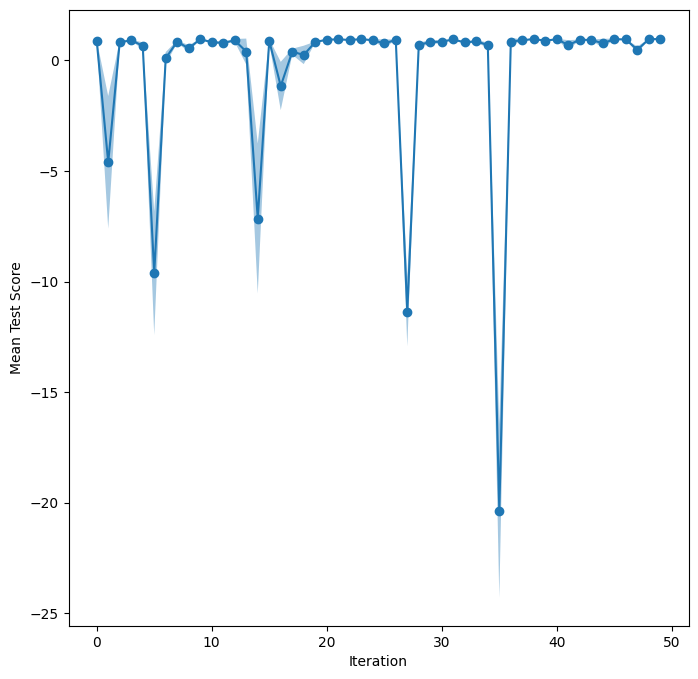

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuner.convergence_plot(model_types="FNN")

Fewer than 30 iterations were required to converge to the optimal parameter configurations.

## Model Post-processing

Now that the top `num_configs_saved` saved, we can pass these models to the `PostProcessor` for model comparison and analysis. To improve the `nn` performance we can pass an updated epochs parameter. Using 200 epochs should improve fitting at higher computational cost.

In [39]:
new_model_settings = {
    "FNN": {
        "fitting_params":{
            "epochs": 200,
        }
    }
}
postprocessor = mai.PostProcessor(
    data=data,
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings=new_model_settings,
    yscaler=yscaler,
)

To compare the performance of these models, we will compute 4 metrics for both the training and testing data: 

In [40]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
24,FNN,"{'Dense_input_0_units': 72, 'Dense_input_0_sub...",0.993073,0.652085,1.311806,1.145341,0.988645,0.762253,1.798126,1.340942
23,FNN,"{'Dense_input_0_units': 152, 'Dense_input_0_su...",0.991280,0.677876,1.394466,1.180875,0.985330,0.789226,1.861788,1.364474
22,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.993482,0.489806,0.844584,0.919012,0.983041,0.776493,1.903701,1.379747
25,FNN,"{'Dense_input_0_units': 85, 'Dense_input_0_sub...",0.986122,1.256693,4.639882,2.154039,0.981606,1.244385,4.582352,2.140643
4,Lasso,{'alpha': 0.00016568131760704411},0.980006,0.905219,2.270680,1.506878,0.974824,0.946132,2.618025,1.618031
5,Lasso,{'alpha': 0.00018763709907941348},0.979938,0.909559,2.297918,1.515888,0.974822,0.947542,2.633853,1.622915
3,Lasso,{'alpha': 0.0001361115327882044},0.980085,0.899856,2.239348,1.496445,0.974817,0.945192,2.600770,1.612690
2,Lasso,{'alpha': 0.00012130523841494747},0.980119,0.897740,2.225966,1.491967,0.974808,0.945249,2.593882,1.610553
1,Lasso,{'alpha': 0.00011581388623766684},0.980131,0.897039,2.221395,1.490434,0.974803,0.945371,2.591625,1.609852
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.980278,0.886975,2.154051,1.467668,0.974521,0.959344,2.605819,1.614255


Given the top performing models are `Linear` and `Lasso`, and `FN` this data set's outputs are linear with their inputs. `nn` also performs well for the linear data. Performance quickly drops off with `rforest`, `knn`, and `dtree`. We can look specifically at the performance for each output:

In [41]:
postprocessor.metrics(y="fis_gas_produced")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.999270,3.065292e-08,1.532784e-15,3.915078e-08,0.999218,3.798260e-08,1.922844e-15,4.385025e-08
1,Lasso,{'alpha': 0.00011581388623766684},0.999209,3.196379e-08,1.661558e-15,4.076222e-08,0.999201,3.746836e-08,1.966559e-15,4.434590e-08
2,Lasso,{'alpha': 0.00012130523841494747},0.999204,3.201911e-08,1.671075e-15,4.087879e-08,0.999197,3.751929e-08,1.975613e-15,4.444786e-08
3,Lasso,{'alpha': 0.0001361115327882044},0.999194,3.214964e-08,1.692022e-15,4.113419e-08,0.999187,3.764059e-08,1.999753e-15,4.471860e-08
4,Lasso,{'alpha': 0.00016568131760704411},0.999172,3.242577e-08,1.737893e-15,4.168804e-08,0.999164,3.791731e-08,2.055457e-15,4.533714e-08
5,Lasso,{'alpha': 0.00018763709907941348},0.999153,3.269318e-08,1.777768e-15,4.216358e-08,0.999145,3.813702e-08,2.104124e-15,4.587073e-08
23,FNN,"{'Dense_input_0_units': 152, 'Dense_input_0_su...",0.999267,2.970008e-08,1.538857e-15,3.922826e-08,0.998970,4.092476e-08,2.533885e-15,5.033771e-08
22,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.998883,3.952887e-08,2.345574e-15,4.843113e-08,0.998548,4.774177e-08,3.572491e-15,5.977032e-08
24,FNN,"{'Dense_input_0_units': 72, 'Dense_input_0_sub...",0.998102,5.440399e-08,3.984663e-15,6.312419e-08,0.998534,5.165492e-08,3.605455e-15,6.004544e-08
25,FNN,"{'Dense_input_0_units': 85, 'Dense_input_0_sub...",0.997797,5.400242e-08,4.626916e-15,6.802144e-08,0.997986,5.663594e-08,4.954028e-15,7.038486e-08


For fission gas production, decision tree out performs k-nearest neighbors. Additionally, fission gas production is well modeled by linear ML models (greater than 0.99 r-squared). The general exception to the outperformance to non-linear models is FN models.

In [42]:
postprocessor.metrics(y="max_fuel_centerline_temp")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.998482,1.190017,2.176318,1.475235,0.996663,1.724797,4.553752,2.133952
23,FNN,"{'Dense_input_0_units': 152, 'Dense_input_0_su...",0.997386,1.666674,3.748808,1.936184,0.996565,1.778388,4.688089,2.165199
24,FNN,"{'Dense_input_0_units': 72, 'Dense_input_0_sub...",0.997215,1.789769,3.993486,1.998371,0.996178,1.954242,5.215171,2.283675
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.997150,1.678856,4.086441,2.021495,0.996127,1.860222,5.285960,2.299122
1,Lasso,{'alpha': 0.00011581388623766684},0.996970,1.707762,4.344635,2.084379,0.996113,1.816831,5.304182,2.303081
2,Lasso,{'alpha': 0.00012130523841494747},0.996958,1.710016,4.361857,2.088506,0.996105,1.816836,5.315931,2.305630
3,Lasso,{'alpha': 0.0001361115327882044},0.996923,1.716988,4.412267,2.100540,0.996079,1.817944,5.350633,2.313143
4,Lasso,{'alpha': 0.00016568131760704411},0.996841,1.735460,4.530300,2.128450,0.996019,1.823681,5.433140,2.330910
5,Lasso,{'alpha': 0.00018763709907941348},0.996769,1.750561,4.632905,2.152418,0.995965,1.830763,5.505785,2.346441
25,FNN,"{'Dense_input_0_units': 85, 'Dense_input_0_sub...",0.988435,3.883959,16.583560,4.072292,0.988513,3.673707,15.675992,3.959292


The max fuel centerline temperature results closely follow the averaged results with decision tree back at the bottom.

In [43]:
postprocessor.metrics(y="max_fuel_surface_temp")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
24,FNN,"{'Dense_input_0_units': 72, 'Dense_input_0_sub...",0.979947,0.818572,1.253737,1.119704,0.964072,1.094769,1.977332,1.406176
25,FNN,"{'Dense_input_0_units': 85, 'Dense_input_0_sub...",0.968396,1.142813,1.975969,1.405692,0.951788,1.303832,2.653418,1.628932
23,FNN,"{'Dense_input_0_units': 152, 'Dense_input_0_su...",0.970745,1.044829,1.829055,1.352426,0.949868,1.378516,2.759063,1.661043
22,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.980775,0.769208,1.202016,1.096365,0.944381,1.381174,3.061051,1.749586
21,FNN,"{'Dense_input_0_units': 166, 'Dense_input_0_su...",0.954435,1.390264,2.848805,1.687840,0.909393,1.760924,4.986659,2.233083
5,Lasso,{'alpha': 0.00018763709907941348},0.927086,1.887675,4.558765,2.135127,0.908612,1.959403,5.029629,2.242683
4,Lasso,{'alpha': 0.00016568131760704411},0.927187,1.885415,4.552422,2.133641,0.908443,1.960846,5.038960,2.244763
3,Lasso,{'alpha': 0.0001361115327882044},0.927304,1.882437,4.545125,2.131930,0.908198,1.962825,5.052448,2.247765
2,Lasso,{'alpha': 0.00012130523841494747},0.927354,1.880946,4.542008,2.131199,0.908068,1.964160,5.059599,2.249355
1,Lasso,{'alpha': 0.00011581388623766684},0.927371,1.880393,4.540943,2.130949,0.908018,1.964654,5.062318,2.249960


The max fuel surface temperature is the output with the worst results for all models. All models struggle to predict this output with none predicting greater than 0.95 r-squared.

In [44]:
postprocessor.metrics(y="radial_clad_dia")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.997143,3.446591e-08,1.896737e-15,4.355154e-08,0.996082,3.768320e-08,2.420066e-15,4.919416e-08
23,FNN,"{'Dense_input_0_units': 152, 'Dense_input_0_su...",0.997722,3.081387e-08,1.512664e-15,3.889299e-08,0.995918,3.949620e-08,2.521388e-15,5.021343e-08
1,Lasso,{'alpha': 0.00011581388623766684},0.996974,3.502870e-08,2.009085e-15,4.482282e-08,0.995878,3.804652e-08,2.545949e-15,5.045740e-08
2,Lasso,{'alpha': 0.00012130523841494747},0.996958,3.510610e-08,2.019742e-15,4.494154e-08,0.995862,3.810048e-08,2.556348e-15,5.056034e-08
3,Lasso,{'alpha': 0.0001361115327882044},0.996918,3.533336e-08,2.046606e-15,4.523943e-08,0.995803,3.831323e-08,2.592619e-15,5.091777e-08
24,FNN,"{'Dense_input_0_units': 72, 'Dense_input_0_sub...",0.997027,3.635704e-08,1.974236e-15,4.443237e-08,0.995796,4.142578e-08,2.596842e-15,5.095922e-08
4,Lasso,{'alpha': 0.00016568131760704411},0.996824,3.584402e-08,2.108674e-15,4.592030e-08,0.995672,3.884171e-08,2.673476e-15,5.170567e-08
5,Lasso,{'alpha': 0.00018763709907941348},0.996743,3.630713e-08,2.162692e-15,4.650475e-08,0.995564,3.928429e-08,2.740059e-15,5.234557e-08
22,FNN,"{'Dense_input_0_units': 400, 'Dense_input_0_su...",0.995788,4.667101e-08,2.796843e-15,5.288519e-08,0.992571,5.678448e-08,4.589246e-15,6.774398e-08
25,FNN,"{'Dense_input_0_units': 85, 'Dense_input_0_sub...",0.989862,7.400918e-08,6.731657e-15,8.204668e-08,0.988138,7.509227e-08,7.327312e-15,8.559972e-08


The performance metrics for radial cladding diameter follow the averaged results.

We can see the parameters of each model with the best `Test R2` with `get_params`.

In [50]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00011581388623766684

Model Types: DT
max_depth: 32
max_features: None
min_samples_leaf: 4
min_samples_split: 7

Model Types: RF
criterion: poisson
max_features: 6
min_samples_leaf: 1
min_samples_split: 6
n_estimators: 157

Model Types: KN
leaf_size: 11
n_neighbors: 7
p: 2
weights: uniform

Model Types: FNN
Dense_input_0_units: 152
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.5584673200996804
Dense_hidden_num_layers: 2
Adam_learning_rate: 0.0005606443036708423
batch_size: 16
Dense_hidden_0_units: 194
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.4101408993521496
Dense_hidden_1_units: 88
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.5500865381152764



We can visualize the performance of each model with diagonal validation plots. These plots show the predicted output to the actual output. For the plots below we will do max fuel surface temperature.

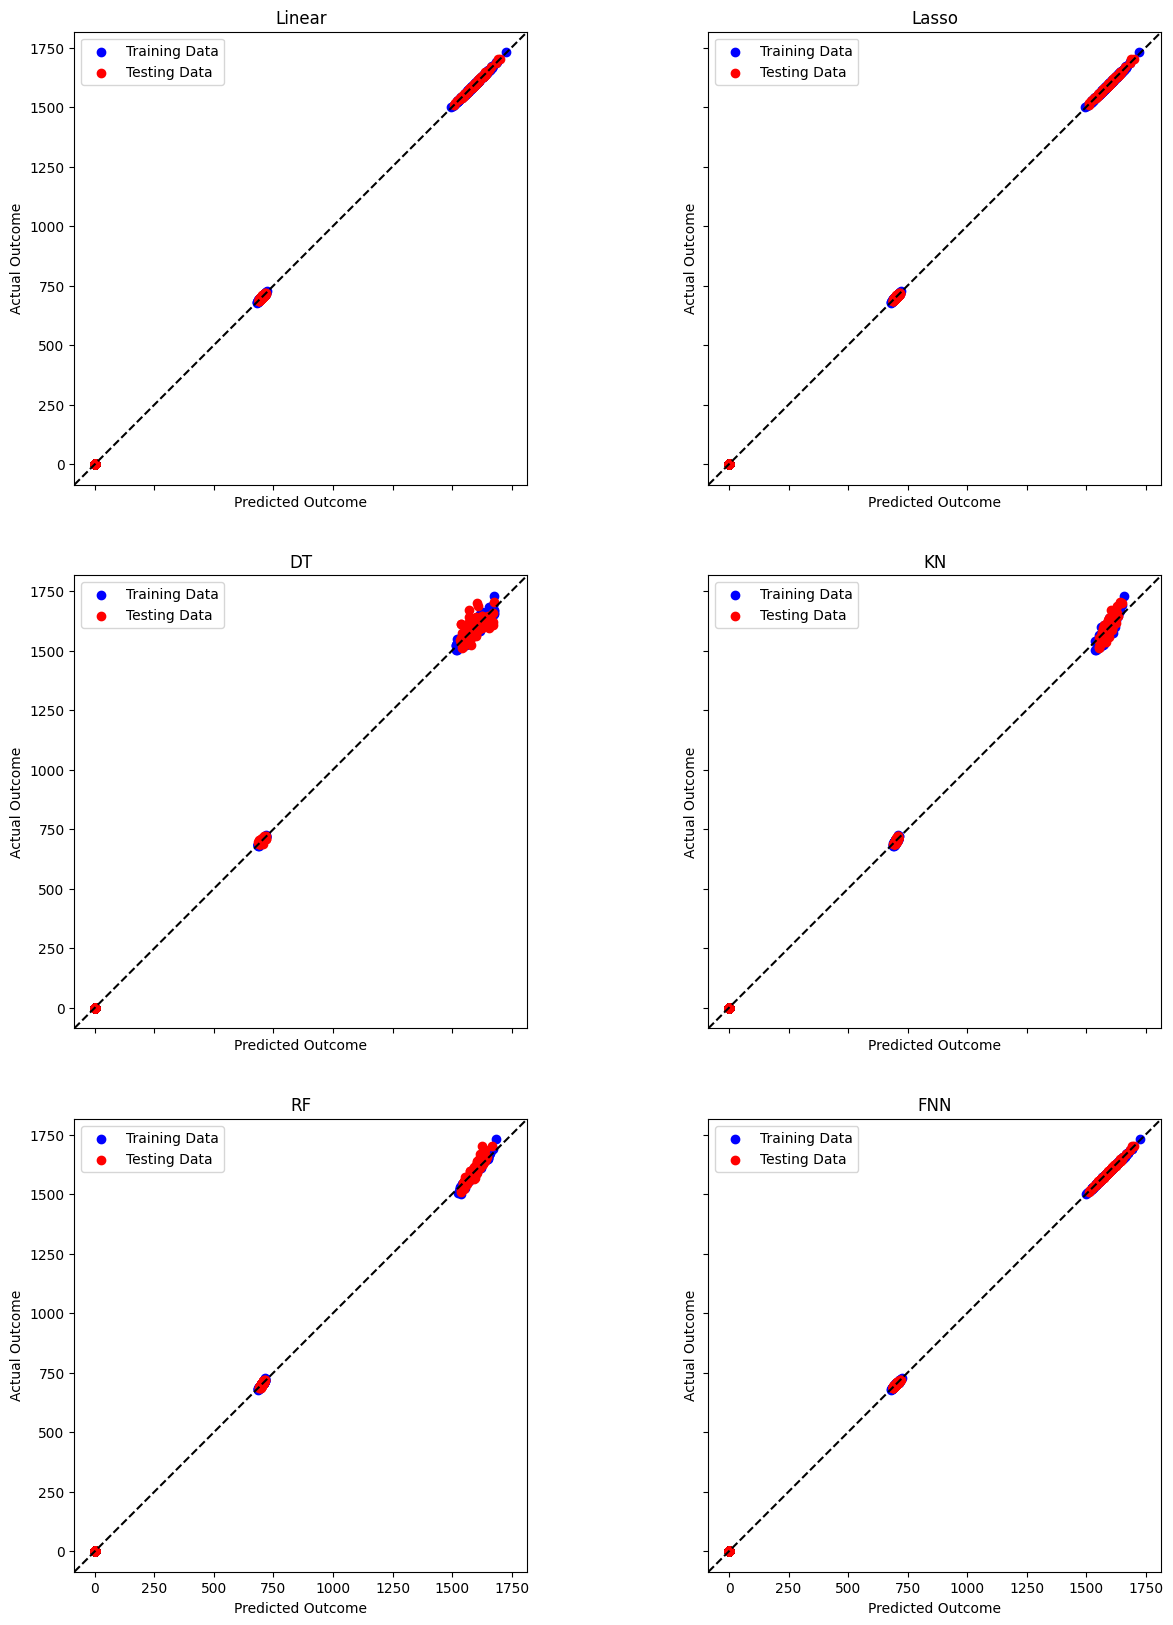

In [46]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

With these plots we can see the narrow spread of `linear`, `lasso`, and `nn` to $y = x$, the best possible performance of a model. Additionally, `knn` appears to be overfit to the training data set and the preditions of `nn` under 700 K under-approximate the max fuel surface temperature. 

Similarly, the `validation_plot` function produces validation plots that show the absolute relative error for each max fuel surface temperature prediction.

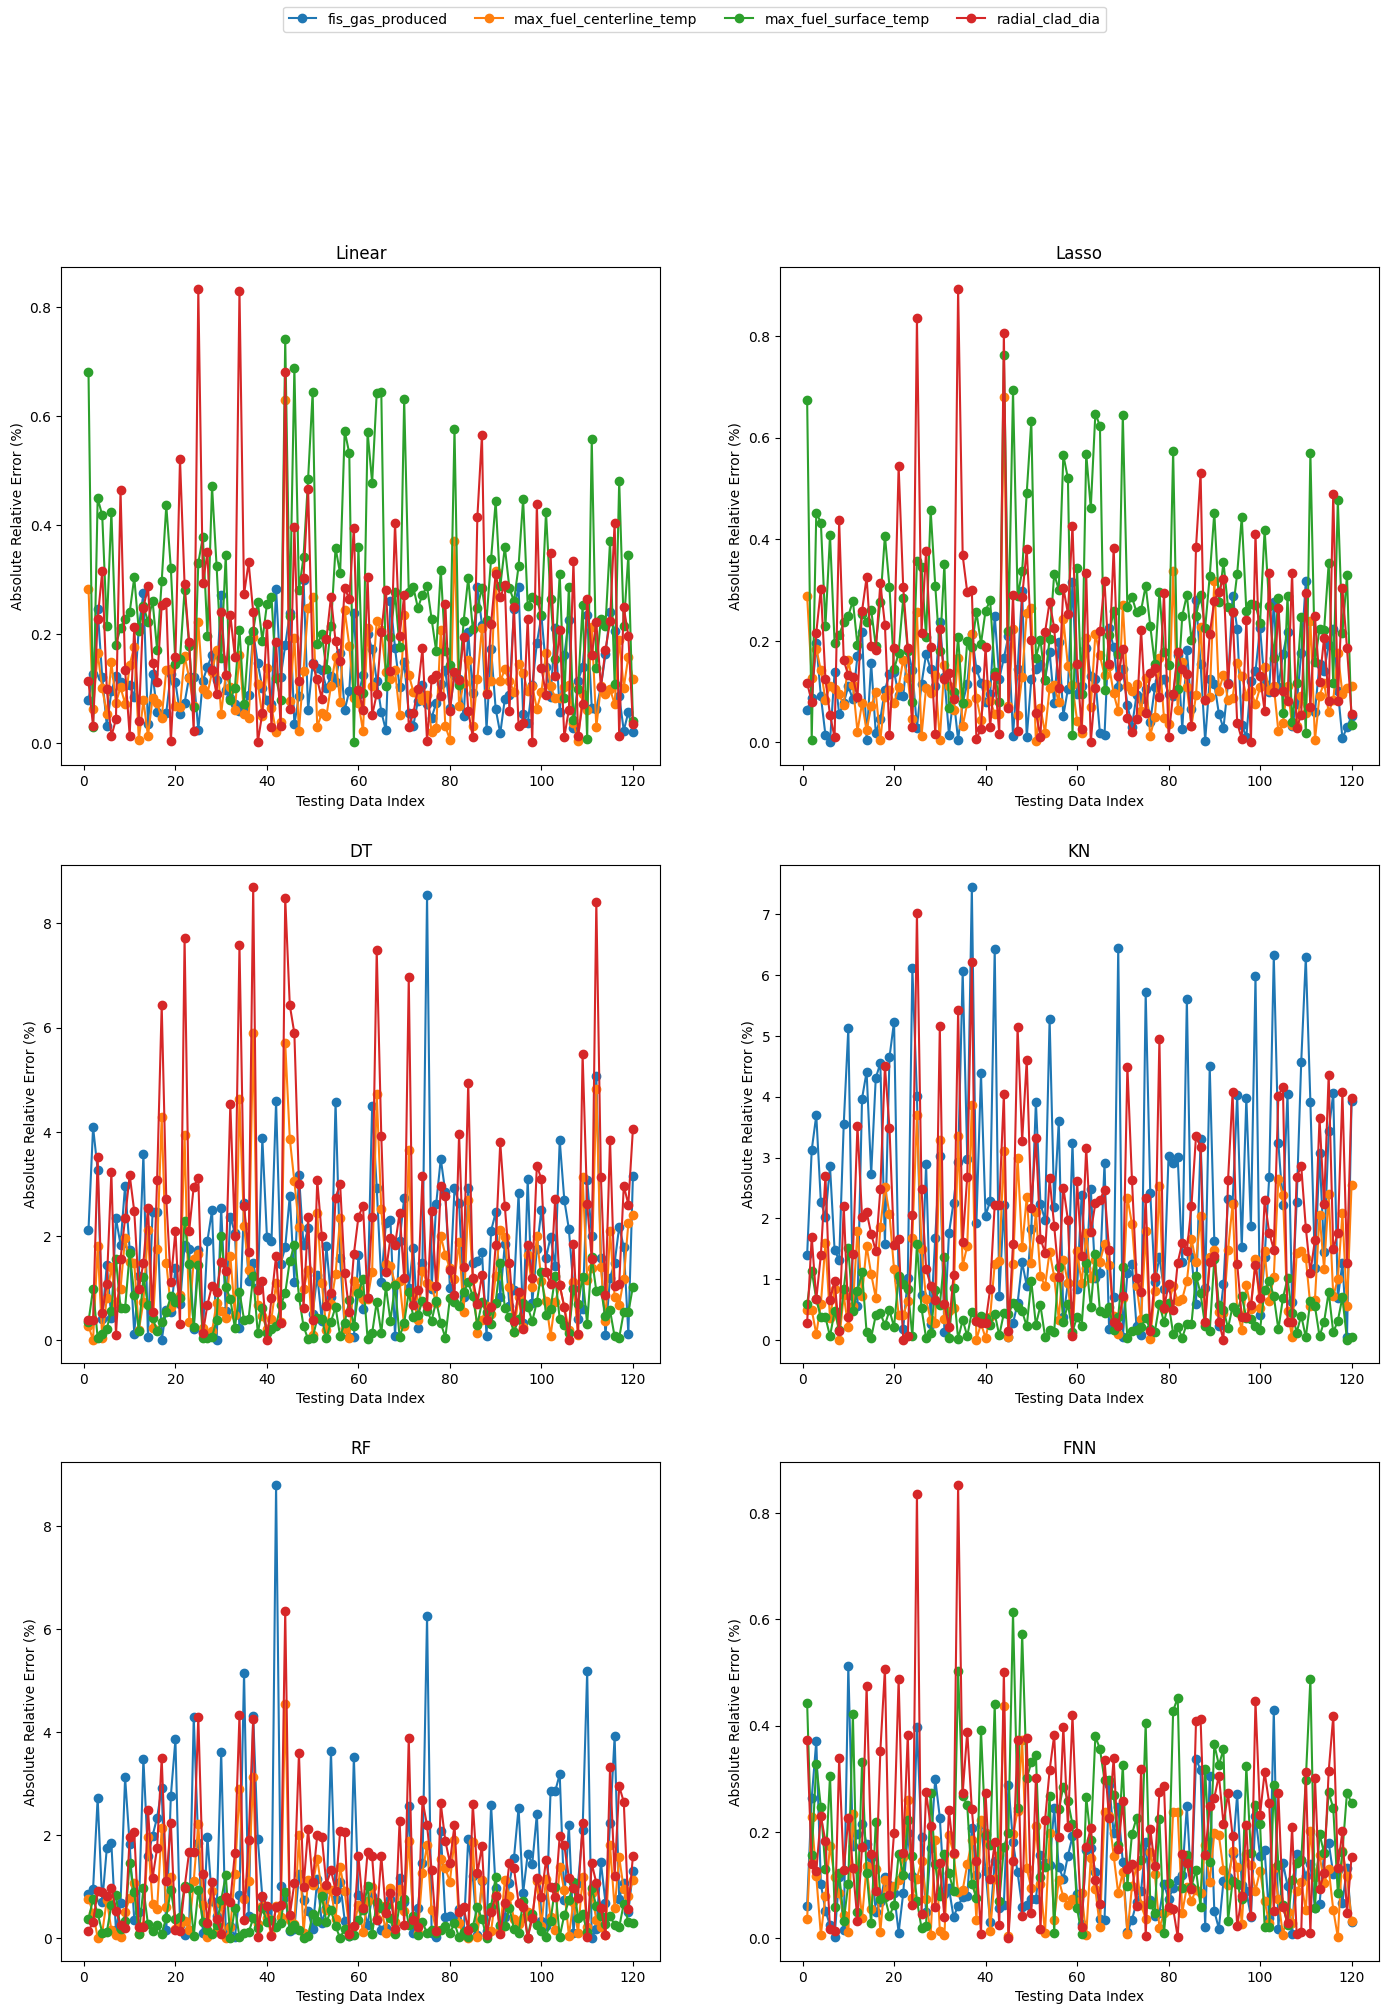

In [47]:
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

y = ["fis_gas_produced", "max_fuel_centerline_temp", "max_fuel_surface_temp", "radial_clad_dia"]

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y)
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(y, loc="upper center", ncol=4)

The performance gap of the linear model to the others is evident in the magnitude of the relative error. There is also one common outlier between `linear`, `lasso`, `dtree`, and `rforest` between 80 and 100. 

Finally, the learning curve of the most performant `nn` is shown by `nn_learning_plot`.

In [48]:
postprocessor.nn_learning_plot()

AssertionError: 

The validation curve is below the training curve; therefore, the `nn` is not overfit. 

## References

1. M. I. RADAIDEH and T. KOZLOWSKI, “Surrogate modeling of advanced computer simulations using deep Gaussian processes,” Reliability Engineering System Safety, 195, 106731 (2020).
2. Rossiter, G., Massara, S., & Amaya, M. (2016). OECD/NEA benchmark on pellet-clad mechanical interaction modelling with fuel performance codes (AECL-CW--124600-CONF-004). Canada

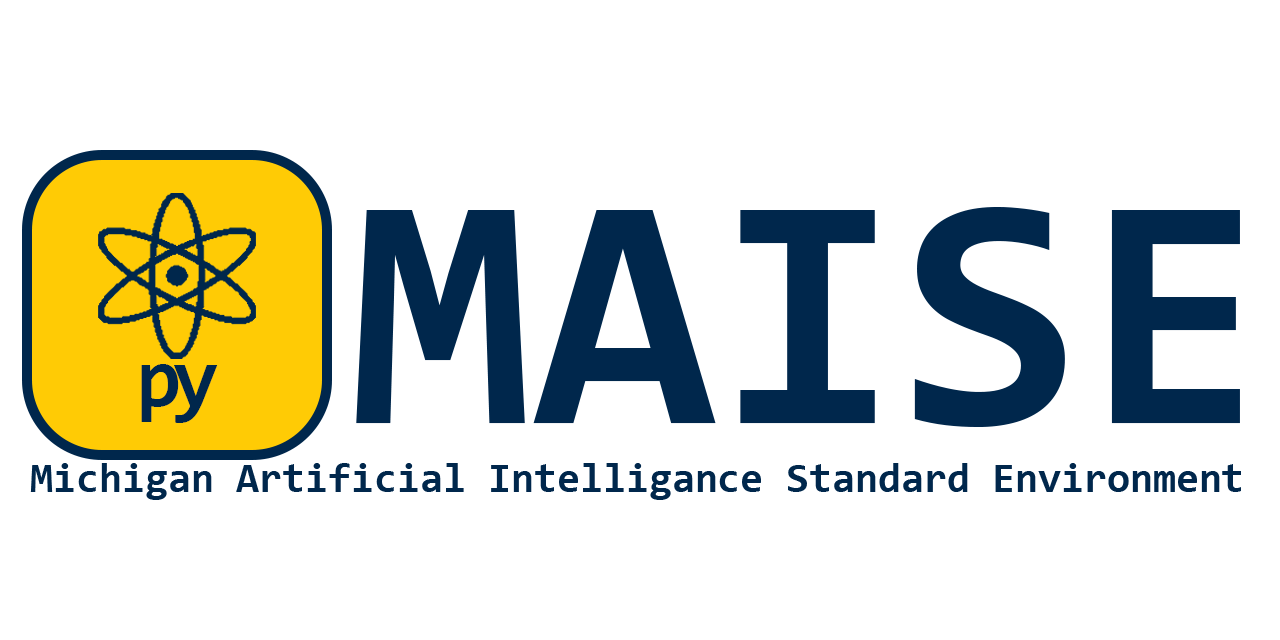